# Fake job Prediction: Investigating the pattern to avoid the job scam

# Notebook 4 Modeling

**Fourth setp: Modeling**

By: Polly Pang

In this portion of the notebook, I will working on the NLP process, convert text column into parse metrics. Create baseline model and base on the baseline do some further study.

----

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home"> Contents</h3>

* [1. Libraries](#1)
* [2. NLP](#2)
    - [2.1 Target and Feature](#2.1)
    - [2.2 vectorization](#2.2)
    - [2.2 vectorization](#2.3)
* [3. Modeling](#3)
    - [3.1 DummyClassifier and baseline](#3.1)
    - [3.2 oversampling](#3.2)
    - [3.3 Logistic regression](#3.3)
    - [3.4 KNN](#3.4)
    - [3.5 Random Forests](#3.5)
    - [3.6 XGBoost](#3.6)

    
    
    
* [7. End of Notebook 4](#7)

# 1. Libraries <a id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import pickle

# NLP 
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer

#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_val_score


from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report



from imblearn.over_sampling import SMOTE

# model
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
model_df=joblib.load('data/df_model_full_df.pkl')

In [3]:
model_df.head()

,has_salary_range,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,0,1,0,0,"Marketing Intern Marketing We're Food52, and w..."
1,0,0,1,0,0,Commissioning Machinery Assistant (CMA) Blank ...
2,0,0,1,0,0,Account Executive - Washington DC Sales Our pa...
3,0,0,1,1,0,Bill Review Manager Blank SpotSource Solutions...
4,0,0,0,0,0,Accounting Clerk Blank Blank Job OverviewApex ...


---

# 2. NLP

## 2.1 Target and Feature<a id="2.1"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**plan**
- Define X and y, Target :`fraudulent`, Features:`has_salary_range`,`telecommuting`,`has_company_logo`,`has_questions`,and `text`.
- split data into test set and reminder set, as I will process Cross-Validation in the follwing part, so I will not split my dataset into train and test.
- investigate the distribustion of reminder set.

In [4]:
# X and y
X=model_df.drop('fraudulent',axis=1)
y=model_df['fraudulent']

In [5]:
# rows x columns
print(f'The shape of Target is {y.shape}, and shape of feature is {X.shape}')

The shape of Target is (17879,), and shape of feature is (17879, 5)


In [6]:
X_rem,X_test,y_rem,y_test=train_test_split(X,y,test_size=0.3,random_state=5, stratify=y)

In [7]:
# take a look at X_rem
X_rem.head()

,has_salary_range,telecommuting,has_company_logo,has_questions,text
4310,0,0,1,1,Creative Director - Art Blank Kettle is an ind...
11082,0,0,1,0,"CDL Driver Blank ABC Supply Co., Inc. is the n..."
14188,0,0,1,0,Data Analyst (Marketing) Blank Blank We are lo...
8280,0,0,1,1,Channel Representative Blank Intercom (# is a ...
13924,0,0,1,0,Programmatic Media Manager Media Since 1978Our...


In [10]:
y_rem.unique()

array([0, 1], dtype=int64)

In [11]:
print(f"The shape of X_rem is {X_rem.shape}")
print(f"The shape of X_test is {X_test.shape}")

The shape of X_rem is (12515, 5)
The shape of X_test is (5364, 5)


In [12]:
print(f"The shape of y_rem is {y_rem.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of y_rem is (12515,)
The shape of y_test is (5364,)


**Distribution of y_train**

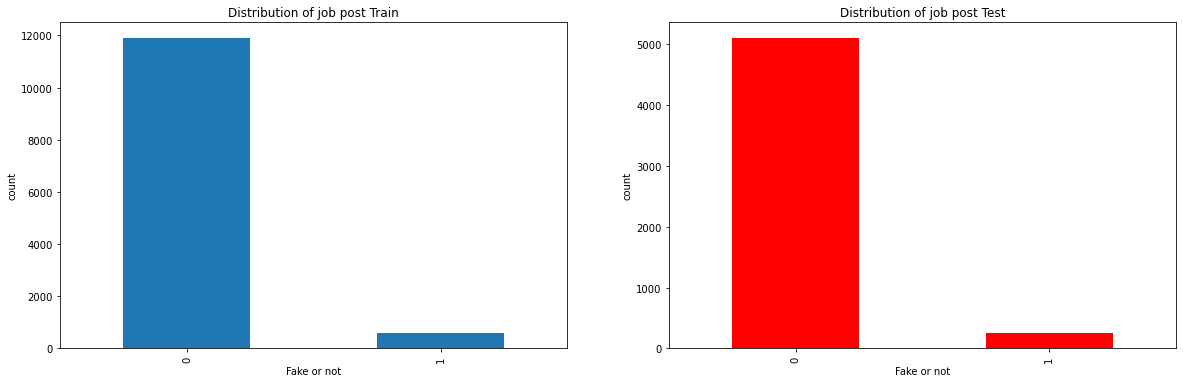

In [11]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
y_rem.value_counts().plot(kind='bar')
plt.title("Distribution of job post Train")
plt.xlabel("Fake or not")
plt.ylabel('count')

plt.subplot(1,2,2)
y_test.value_counts().plot(kind='bar',color='red')
plt.title("Distribution of job post Test")
plt.xlabel("Fake or not")
plt.ylabel('count')
plt.show()

- It is clear the train set is very embalanced, I need to balace the train set before modeling.
- I don't want to touch test set, as most of the process on the test set may cause data leaking, or introduce bais in the test set.
- The test set may need upsampling to make it more balance, I will do some further investigate in the following part.

## 2.2 vectorization <a id="2.2"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Some terminologies of NLP, moving forward I will use these keywords to explain my process.



| Term  | Definition| |
| -------| -------- | --- |
|**Corpus** |           | The entire collection of individual text files in the whole dataset. | |
|**Document** |           | A single or individual text file. | |
|**Token** |           | Processed words from the document; can be multiple words. | |
|**Vocabulary** |           | Collection of the tokens from the corpus. | |


**Plan**:

Function tokenizer:
- Implement Stemmer
- Remove Punctuation
- Remove Stopwords
- Stem words

In [13]:
# init stemmer
stemmer = nltk.stem.PorterStemmer()
# make tokens
def tokenizer(text):
    non_pun=''.join([w for w in text.lower() if w not in string.punctuation])
    #print(type(non_pun),non_pun)

    lst_words=non_pun.split(' ')
    #print(lst_words)
    # remove stop words and stem
    lst_out=[]
    for w in lst_words:
        if (w not in stopwords.words('english')) and (w != ""):
            stemmed_word = stemmer.stem(w)
            lst_out.append(stemmed_word)
    return lst_out

In [14]:
# a sample of the text data
X_rem['text'][1]

"Commissioning Machinery Assistant (CMA) Blank Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp; Gas Industry. Valor Services will be involved with you throughout every step of the hiring process and remain in contact with you all the way through the final step of signing of the employment contract with your new employer. Valor Services was founded with the vision of employing the unique skills, experiences, and qualities of America s finest veterans to provide Private Sector companies with precise and concerted value-added services and America s finest Veterans with an optimized career opportunity.We are eager to get the word out to veterans that there are ample opportunities for employment in the private sector and that you are the ideal candidates to fill those positions. Valor Services Your Success is Our Mission. Our client, located in Houston, is actively seeking an experienced Commissioni

**test my customized tokenizer**

In [14]:
# test function tokenizer 
tokenizer(X_rem['text'][1])

['commiss',
 'machineri',
 'assist',
 'cma',
 'blank',
 'valor',
 'servic',
 'provid',
 'workforc',
 'solut',
 'meet',
 'need',
 'compani',
 'across',
 'privat',
 'sector',
 'special',
 'focu',
 'oil',
 'amp',
 'ga',
 'industri',
 'valor',
 'servic',
 'involv',
 'throughout',
 'everi',
 'step',
 'hire',
 'process',
 'remain',
 'contact',
 'way',
 'final',
 'step',
 'sign',
 'employ',
 'contract',
 'new',
 'employ',
 'valor',
 'servic',
 'found',
 'vision',
 'employ',
 'uniqu',
 'skill',
 'experi',
 'qualiti',
 'america',
 'finest',
 'veteran',
 'provid',
 'privat',
 'sector',
 'compani',
 'precis',
 'concert',
 'valuead',
 'servic',
 'america',
 'finest',
 'veteran',
 'optim',
 'career',
 'opportunityw',
 'eager',
 'get',
 'word',
 'veteran',
 'ampl',
 'opportun',
 'employ',
 'privat',
 'sector',
 'ideal',
 'candid',
 'fill',
 'posit',
 'valor',
 'servic',
 'success',
 'mission',
 'client',
 'locat',
 'houston',
 'activ',
 'seek',
 'experienc',
 'commiss',
 'machineri',
 'assist',
 'po

**Text column and numerical column** 
- My numerical columns are all binary columns, so I don't need to apply scale or transfor them.

### Two types of Vectorizers:

**Count-Vectorizer (Bag-of-Words)**: CountVectorizer takes as input a list of strings, where each string represents a document. It then tokenizes the text. Once the text is tokenized, the CountVectorizer counts the number of occurrences of each token (word) in each document and returns a sparse matrix, where each row represents a document and each column represents a token (word). The value in a cell is the count of that word in that document.

**TF-IDF:**
The term frequency (TF) is the number of times a word appears in a document divided by the total number of words in the document.The IDF is used to de-emphasize words that appear frequently across all documents in the corpus. As a result the words that appear frequently in a document but not frequently across all documents will have a higher TF-IDF score.

I will vectorize my dataset with Count-Vectorizer and TF-IDF, base on the transformed new dataset, I will process modedling, the reason why I don't put these step in one piece is, my dataset contains a large amount of text data, the running time of the whole pipline and gridsearch is super high. I am going to break the pipline into 2 parts. (My loptop has limited cumputing capacity,I will try to process the full pipline will kfoklder in the big data platform in the feature.)


**Plan**
- use ColumnTransformer to transform text column and numerical column at one time.
- Text colum need to remove Punctuation, stopwords,tokenlize and Stem.
- Finally get transfromed X_rem and X_test in with 2 different Vectorizers (Count-Vectorizer and TF-IDF)



In [15]:
numerical = list(X_rem.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Numerical columns are: ['has_salary_range', 'telecommuting', 'has_company_logo', 'has_questions']


In [16]:
text = [X_rem.columns[4]]
print(f"Categorical columns are: {text}")

Categorical columns are: ['text']


**Note: If you choose to load Vectorized df from my result, you can pass this section from here, jump directly to 3 Modeling.**

**Count-Vectorizer**

In [31]:
# columntransforms with Count-Vectorizer
col_transforms = [('num','passthrough', numerical),
                ('tokenizer', CountVectorizer(tokenizer=tokenizer,min_df=5), 'text')]

In [ ]:
# Create the column transformer
# note if u choose load df from my result, this cell can be pass
col_trans = ColumnTransformer(col_transforms)

# Fit
col_trans.fit(X_rem)

In [ ]:
# transform X_rem
# note if u choose load df from my result, this cell can be pass
X_rem_count= col_trans.transform(X_rem)

In [ ]:
# transform X_test
# note if u choose load df from my result, this cell can be pass
X_test_count=col_trans.transform(X_test)

In [ ]:
# note if u choose load df from my result, this cell can be pass
X_rem_count.shape

In [ ]:
# note if u choose load df from my result, this cell can be pass
X_test_count.shape

In [ ]:
# Save sparse matrix
# note if u choose load df from my result, this cell can be pass
joblib.dump(X_rem_count, 'vectorized_df/matrix_rem_c.pkl')
joblib.dump(X_test_count, 'vectorized_df/matrix_test_c.pkl')

**Vectorized X_rem dataframe (CountVectorizer)**

In [ ]:
# get feature_names
# note if u choose load df from my result, this cell can be pass
cols_rem_c=col_trans.get_feature_names_out()

In [57]:
# transformed_rem_df
# note if u choose load df from my result, this cell can be pass
CountVectorizer_rem_df = pd.DataFrame(X_rem_count.toarray(), columns=cols_rem_c)
CountVectorizer_rem_df.head()

,num__has_salary_range,num__telecommuting,num__has_company_logo,num__has_questions,tokenizer__0,tokenizer__000,tokenizer__01,tokenizer__02,tokenizer__03,tokenizer__0415,...,tokenizer__zombi,tokenizer__zone,tokenizer__zoom,tokenizer__zoopla,tokenizer__zopa,tokenizer__zu,tokenizer__zullen,tokenizer__zult,tokenizer__zweig,tokenizer__zylun
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Vectorized X_test dataframe (CountVectorizer)**

In [58]:
# get feature_names
# note if u choose load df from my result, this cell can be pass
cols_test_c=col_trans.get_feature_names_out()

In [59]:
# transformed_test_df
# note if u choose load df from my result, this cell can be pass
CountVectorizer_test_df  = pd.DataFrame(X_test_count.toarray(), columns=cols_test_c)
CountVectorizer_test_df.head()

,num__has_salary_range,num__telecommuting,num__has_company_logo,num__has_questions,tokenizer__0,tokenizer__000,tokenizer__01,tokenizer__02,tokenizer__03,tokenizer__0415,...,tokenizer__zombi,tokenizer__zone,tokenizer__zoom,tokenizer__zoopla,tokenizer__zopa,tokenizer__zu,tokenizer__zullen,tokenizer__zult,tokenizer__zweig,tokenizer__zylun
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
print(f'The shape of trainsformed X_train is {CountVectorizer_rem_df.shape}, and the shape of trainsformed X_test is {CountVectorizer_test_df.shape}')

The shape of trainsformed X_train is (12515, 18583), and the shape of trainsformed X_test is (5364, 18583)


**save trainsfromed df (CountVectorizer)**

In [61]:
# Save df into pickle file
# note if u choose load df from my result, this cell can be pass
joblib.dump(CountVectorizer_test_df, 'vectorized_df/CountVectorizer_test_df.pkl')
joblib.dump(CountVectorizer_rem_df, 'vectorized_df/CountVectorizer_rem_df.pkl')

['vectorized_df/CountVectorizer_rem_df.pkl']

**TF-IDF**

In [75]:
# columntransforms
# note if u choose load df from my result, this cell can be pass
col_transforms_t = [('num','passthrough', numerical),
                ('tokenizer', TfidfVectorizer(tokenizer=tokenizer,min_df=5), 'text')]
col_trans_t = ColumnTransformer(col_transforms_t)

# Fit
col_trans_t.fit(X_rem)

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['has_salary_range', 'telecommuting',
                                  'has_company_logo', 'has_questions']),
                                ('tokenizer',
                                 TfidfVectorizer(min_df=5,
                                                 tokenizer=<function tokenizer at 0x00000223D255E8B0>),
                                 'text')])

In [76]:
# transform X_rem
# note if u choose load df from my result, this cell can be pass
X_rem_tf= col_trans_t.transform(X_rem)
# transform X_test
X_test_tf= col_trans_t.transform(X_test)

In [77]:
# note if u choose load df from my result, this cell can be pass
X_rem_tf.shape

(12515, 18583)

In [78]:
# note if u choose load df from my result, this cell can be pass
X_test_tf.shape

(5364, 18583)

In [79]:
# Save sparse matrix 
# note if u choose load df from my result, this cell can be pass
joblib.dump(X_rem_tf,'vectorized_df/matrix_rem_tf.pkl')
joblib.dump(X_test_tf,'vectorized_df/matrix_test_tf.pkl')

['vectorized_df/matrix_test_tf.pkl']

In [80]:
# get features
cols_rem_tf=col_trans_t.get_feature_names_out()
cols_test_tf=col_trans_t.get_feature_names_out()

In [81]:
# make df
tf_rem_df = pd.DataFrame(X_rem_tf.toarray(), columns=cols_rem_tf)
tf_rem_df.head()

,num__has_salary_range,num__telecommuting,num__has_company_logo,num__has_questions,tokenizer__0,tokenizer__000,tokenizer__01,tokenizer__02,tokenizer__03,tokenizer__0415,...,tokenizer__zombi,tokenizer__zone,tokenizer__zoom,tokenizer__zoopla,tokenizer__zopa,tokenizer__zu,tokenizer__zullen,tokenizer__zult,tokenizer__zweig,tokenizer__zylun
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.041755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
tf_test_df = pd.DataFrame(X_test_tf.toarray(), columns=cols_test_tf)
tf_test_df.head()

,num__has_salary_range,num__telecommuting,num__has_company_logo,num__has_questions,tokenizer__0,tokenizer__000,tokenizer__01,tokenizer__02,tokenizer__03,tokenizer__0415,...,tokenizer__zombi,tokenizer__zone,tokenizer__zoom,tokenizer__zoopla,tokenizer__zopa,tokenizer__zu,tokenizer__zullen,tokenizer__zult,tokenizer__zweig,tokenizer__zylun
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
# print tf-idf transformed df shape
print(f'The shape of trainsformed X_rem is {tf_rem_df.shape}, and the shape of trainsformed X_test is {tf_test_df.shape}')

The shape of trainsformed X_rem is (12515, 18583), and the shape of trainsformed X_test is (5364, 18583)


**save save trainsfromed df (TF-IDF)**

In [84]:
joblib.dump(tf_test_df, 'vectorized_df/TFIDF_test_df.pkl')
joblib.dump(tf_rem_df, 'vectorized_df/TFIDF_rem_df.pkl')

['vectorized_df/TFIDF_rem_df.pkl']

- Looks like with TF-IDF and CountVectorizer I get exactly same sized the transformed dataframe,and the same features.
- The only difference is the count of each features, as these 2 Vectorizers based on different weighting system.

- Moving forword, I will load my previous result instead of create a transformed dataframe again, as this process will cause more extra time.

____

# 3. Modeling <a id="3"></a>

## 3.1 DummyClassifier and baseline<a id="3.1"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**DummyClassifier**: DummyClassifier is a class in the scikit-learn library that can be used as a simple baseline for classification tasks. The DummyClassifier is not designed to be a good classifier, but to serve as a simple, fast and easy-to-use baseline classifier for comparison with other classifiers.

- I will use DummyClassifier to bulid my baseline model, instead of using logistic regression wich is designed for much balanced dataset.

**Note: In order to reduce cumpting time, I will load Vectorized X_rem and X_test directly from the pickled file.**

**Dummy baseline with CountVectorizer**

In [7]:
# load X_rem and X_test
X_rem_count=joblib.load('vectorized_df/CountVectorizer_rem_df.pkl')
X_test_count=joblib.load('vectorized_df/CountVectorizer_test_df.pkl')

In [8]:
# check shape
print(f'the shpe of reminder is {X_rem_count.shape},test is {X_test_count.shape}')

the shpe of reminder is (12515, 18583),test is (5364, 18583)


In [59]:
# fit with reminder maybe cause data leak, BUt not going to run a gridsearch on the DummyClassifier
#as there are no hyperparameter need to be tuned
baseline_c = DummyClassifier() 
baseline_c.fit(X_rem_count, y_rem)

# Make predictions
base_score_count=baseline_c.score(X_test_count,y_test)

In [60]:
print(f'The test accuracy with CountVectorizer is {base_score_count}')

The test accuracy with CountVectorizer is 0.9515287099179717


**Dummy baseline with TF-IDF**

In [8]:
# load X_rem and X_test
X_rem_tf=joblib.load('vectorized_df/TFIDF_rem_df.pkl')
X_test_tf=joblib.load('vectorized_df/TFIDF_test_df.pkl')

In [50]:
# check shape
print(f'the shpe of reminder is {X_rem_tf.shape},test is {X_test_tf.shape}')

the shpe of reminder is (12515, 18583),test is (5364, 18583)


In [51]:
baseline_tf=DummyClassifier()
baseline_tf.fit(X_rem_tf, y_rem)
base_score_tf=baseline_tf.score(X_test_tf,y_test)

In [52]:
print(f'The test accuracy with TF_IDF is {base_score_tf}')

The test accuracy with TF_IDF is 0.9515287099179717


**Finding**

- With 2 different Vectorizers, I get a same test accuracy score. 
- 95% of test accuracy is really good, but is this really a working model? I will make a confusion matrix to do the further investigate.
- It is clear this dummy baseline model does a great job on predict real jobs, at the sametime this dummy model dose nothing on find out fake jobs.
- I will use this as a baseline, aim to improve them using other models.
- Why this dummy model not doing well with predict fake job posts? My concern is the imbalace from my dataset.

**ConfusionMatrix** 

Note: As I am using DummyClassifier, base on this CountVectorizer and TF-IDF has a totally same result, I am not going to plot the ConfusionMatrix for TF-IDF.

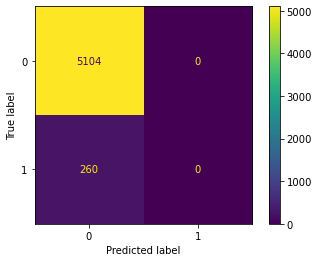

In [62]:
ConfusionMatrixDisplay.from_estimator(baseline_c, X_test_count,y_test)
plt.show()

In [31]:
#baseline_c.predict(X_test_count)
dummy_report_c = classification_report(y_test, baseline_c.predict(X_test_count))
print(dummy_report_c)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      5104
           1       0.00      0.00      0.00       260

    accuracy                           0.95      5364
   macro avg       0.48      0.50      0.49      5364
weighted avg       0.91      0.95      0.93      5364



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- This Waring is saying there exist label that never been perdect.
- **As we see there is nothing in the label 1 part. Which means this dummy model does nothing no perdict Fake job.**

In [32]:
# label 1 is never been perdict----> No fake job has been perdected.
set(y_test) - set(baseline_c.predict(X_test_count))

{1}

In [33]:
y_rem.value_counts(normalize=True)

0    0.951578
1    0.048422
Name: fraudulent, dtype: float64

**I only have 5% fake jobs in the dataset.** 
- I will investigate the imbalance with smote()
---

# 3.2 oversampling<a id="3.2"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**Plan**
- Run a default Logistic regression model with no resampling
- Run a default Logistic regression model with resampling
- compare the result

In [42]:
# split reminder data into train and validation with no smote()
X_train, X_val, y_train, y_val = train_test_split(X_rem_count, y_rem, test_size=0.2, random_state=42,stratify=y_rem)

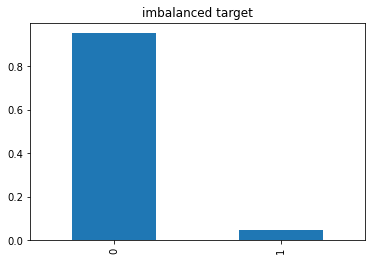

In [35]:
plt.figure()
plt.title('imbalanced target')
y_train.value_counts(normalize=True).plot(kind='bar')
plt.show()

In [36]:
# base Logistic regression with all default parameter
Logistic_d=LogisticRegression()
Logistic_d.fit(X_train,y_train)
Logistic_d.score(X_test_count,y_test)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9806114839671887

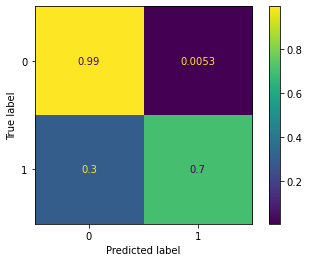

In [37]:
# base Logistic regression with no smote()
ConfusionMatrixDisplay.from_estimator(Logistic_d, X_test_count,y_test,normalize='true')
plt.show()

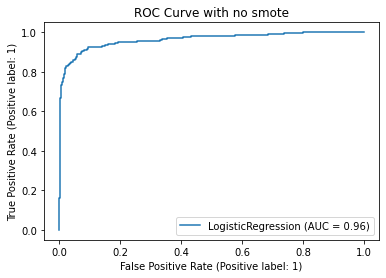

In [49]:
RocCurveDisplay.from_estimator(Logistic_d, X_test_count,y_test)
plt.title('ROC Curve with no smote')
plt.show()

In [38]:
# resampling
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

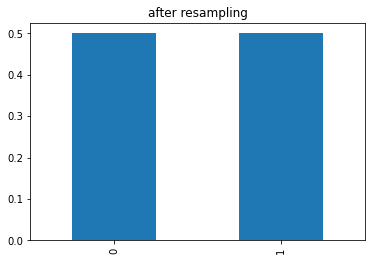

In [39]:
plt.figure()
y_resampled.value_counts(normalize=True).plot(kind='bar')
plt.title('after resampling')
plt.show()

In [40]:
# base Logistic regression with all default parameter after resampling
Logistic_re=LogisticRegression()
Logistic_re.fit(X_resampled,y_resampled)
Logistic_re.score(X_test_count,y_test)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9746457867263236

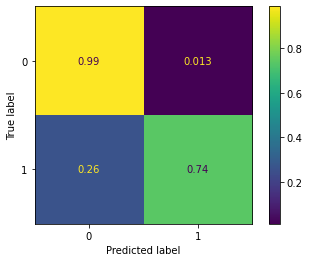

In [41]:
# base Logistic regression with no smote()
ConfusionMatrixDisplay.from_estimator(Logistic_re, X_test_count,y_test,normalize='true')
plt.show()

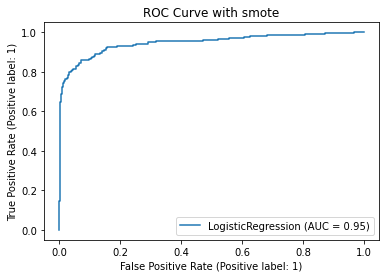

In [42]:
RocCurveDisplay.from_estimator(Logistic_re, X_test_count,y_test)
plt.title('ROC Curve with smote')
plt.show()

- Though after resmapling, the test accuary have a little drop down. 
- But I observed 4% improvement on detect fake job posts. I believe that using somte() to process the resampling will improve the ability to finding out more scam.
----

# 3.3 Logistic regression<a id="3.3"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**Plan**
- Vectorizer: CountVectorizer
  + imbalance care: smote()
  + model: Logistic regression
  + hyperparameter tune: gridsearchCV()

- Vectorizer: TF-IDF
  + imbalance care: smote()
  + model: Logistic regression
  + hyperparameter tune: gridsearchCV()
  
  
**Note This Grid Search will take a long time, If you do not want to run this,pass the pipeline and grid search part,and you can just take my fitting result and load in.**

**CountVectorizer with scaler** 

In [97]:
# define the pipeline
pipe1 = imbPipeline([
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()),
    ('dim_reducer', PCA()),
    ('classifier',LogisticRegression())
])

# define C values
c_values=[0.001, 0.01, 0.1, 1, 10]


logistic_reg_grid=[
    # no pca
    {'classifier__C':c_values,
     'dim_reducer':[None],
    'classifier': [LogisticRegression(penalty='l1', random_state=123, n_jobs=-1,max_iter=1000)],
    'classifier__solver':['saga']},
    # with pca
    {
     'dim_reducer':[PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'classifier': [LogisticRegression(penalty='l1', random_state=123, n_jobs=-1,max_iter=1000)],
     'classifier__C': c_values,
    'classifier__solver':['saga']},
    # L2 with no pca,solver='lbfgs'
    {
     'dim_reducer':[None],
     'classifier': [LogisticRegression(solver='lbfgs',penalty='l2', random_state=123, n_jobs=-1,max_iter=1000)],
     'classifier__C': c_values},
    {
     'dim_reducer':[PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'classifier': [LogisticRegression(solver='lbfgs',penalty='l2', random_state=123, n_jobs=-1,max_iter=1000)],
     'classifier__C': c_values}  
    
]
 

In [98]:
# define GridSearch
halving_cv = HalvingGridSearchCV(pipe1, logistic_reg_grid, n_jobs=-1, min_resources="exhaust", factor=3,verbose=2)

In [99]:
# fit model
logreg_gs_count_fit=halving_cv.fit(X_rem_count,y_rem)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 463
max_resources_: 12515
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 463
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 1
n_candidates: 17
n_resources: 1389
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 2
n_candidates: 6
n_resources: 4167
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 12501
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [102]:
logreg_gs_count_fit.score(X_test_count,y_test)

0.8385533184190902

In [103]:
# dump the result of logreg_gs_fit
joblib.dump(logreg_gs_count_fit,'vectorized_df/logreg_count_fit.pkl')

['vectorized_df/logreg_count_fit.pkl']

In [17]:
# load the fitted Logistic model 
logreg_fit_read=joblib.load('vectorized_df/logreg_gs_fit.pkl')

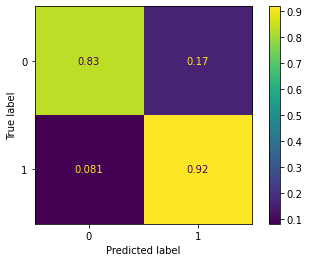

In [105]:
ConfusionMatrixDisplay.from_estimator(logreg_gs_count_fit,X_test_count,y_test,normalize='true')
plt.show()

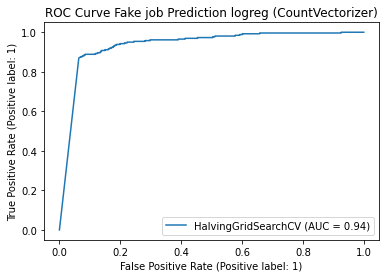

In [112]:
RocCurveDisplay.from_estimator(logreg_gs_count_fit,X_test_count,y_test)
plt.title('ROC Curve Fake job Prediction logreg (CountVectorizer)')
plt.show()

| **Target**  | **Description**                                                                                                                                                                                                                             |
|----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Condition      | 0 = no disease, 1 = disease

**TF-IDF with scaler**

In [101]:
logreg_gs_tf=halving_cv.fit(X_rem_tf, y_rem)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 463
max_resources_: 12515
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 463
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 1
n_candidates: 17
n_resources: 1389
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 2
n_candidates: 6
n_resources: 4167
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 12501
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [107]:
# dump the result of logreg_gs_fit
joblib.dump(logreg_gs_tf,'vectorized_df/logreg_tf_fit.pkl')

['vectorized_df/logreg_tf_fit.pkl']

In [109]:
logreg_gs_tf.score(X_test_tf, y_test)

0.9852721849366145

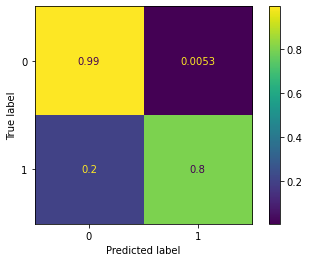

In [110]:
ConfusionMatrixDisplay.from_estimator(logreg_gs_tf,X_test_tf, y_test,normalize='true')
plt.show()

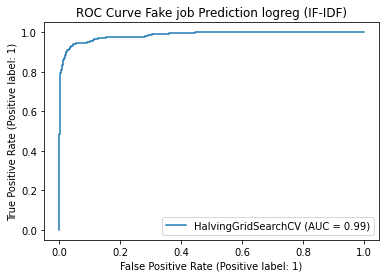

In [111]:
RocCurveDisplay.from_estimator(logreg_gs_tf,X_test_tf, y_test)
plt.title('ROC Curve Fake job Prediction logreg (IF-IDF)')
plt.show()

# 3.4 KNN<a id="3.4"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**some variable use in this session:**

- X_rem_count (X_reminder vectorized by CountVectorizer)
- X_rem_tf (X_reminder vectorized by TF_IDF)
- X_test_tf (x_test vectorized by TF_IDF)

In [35]:
# define pipepline for KNN

pipe_k=imbPipeline([
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()),
    ('dim_reducer', PCA()),
    ('classifier',KNeighborsClassifier())
])

k_list=list(range(3,10))
knn_grid_count=[{
    'dim_reducer':[None],
    'classifier__n_neighbors':k_list,
    'classifier':[KNeighborsClassifier(n_jobs=-1)]
},
{   'dim_reducer':[PCA()],
    'dim_reducer__n_components':[0.95, 0.9, 0.85, 0.8],
    'classifier__n_neighbors':k_list,
    'classifier':[KNeighborsClassifier(n_jobs=-1)]
}        
]


In [36]:
# havlving grid for KNN
halving_knn=HalvingGridSearchCV(pipe_k,knn_grid_count,n_jobs=-1, min_resources="exhaust", factor=3,verbose=2)

**CountVectorizer**

**Note**: The fit process will take a very long time, you can skip these step by using my pre-fit model. `knn_count_fit.pkl`

In [37]:
# CountVectorizer knn model fit 
knn_hv_c=halving_knn.fit(X_rem_count, y_rem)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 463
max_resources_: 12515
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 35
n_resources: 463
Fitting 5 folds for each of 35 candidates, totalling 175 fits
----------
iter: 1
n_candidates: 12
n_resources: 1389
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 4167
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 12501
Fitting 5 folds for each of 2 candidates, totalling 10 fits


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
7 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "D:\anaconda3\lib\site-packages\imblearn\pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __c

In [67]:
# dump with pickle
with open('vectorized_df/knn_count_fit.pkl', 'wb') as f:
    pickle.dump(knn_hv_c, f)

In [29]:
# load fitted model for knn (CountVectorizer)
knn_count_fit_read=joblib.load('vectorized_df/knn_count_fit.pkl')

In [34]:
# best train score for CountVectorizer
best_test_score_c=knn_count_fit_read.score(X_test_count, y_test)

In [41]:
print(f'Best train score using CountVectorizer with knn is {best_test_score_c}.')

Best train score using CountVectorizer with knn is 0.889075316927666.


In [40]:
print(f"The best estimator for model KNN (CountVectorizer){knn_count_fit_read.best_estimator_}")

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', MinMaxScaler()),
                ('dim_reducer', PCA(n_components=0.8)),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])


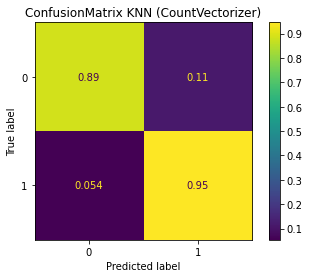

In [38]:
ConfusionMatrixDisplay.from_estimator(knn_count_fit_read,X_test_count, y_test,normalize='true')
plt.title('ConfusionMatrix KNN (CountVectorizer)')
plt.show()

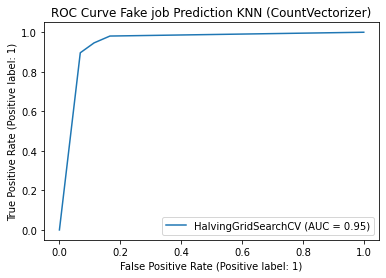

In [39]:
RocCurveDisplay.from_estimator(knn_count_fit_read, X_test_count, y_test)
plt.title('ROC Curve Fake job Prediction KNN (CountVectorizer)')
plt.show()

**Best Result**
- This accuary score is 0.889, obvious this model has a lower accuacy score comapare with the others, or even my base dummy model.
- Does a **GREAT job** for **perdict fake jobs**, it correctly predict 89% of TN and 95% of the TP.
- Although this model did a great job on distinguish fake jobs, but it's test accuracy score is lower than my base line model, I will not choose this model moving forward. 

**TF-IDF**

**Note**: The fit process will take a very long time, you can skip these step by using my pre-fit model. `knn_tf_fit.pkl`

In [92]:
# havlving grid for tf-idf
knn_hv_tf=halving_knn.fit(X_rem_tf, y_rem)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 463
max_resources_: 12515
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 35
n_resources: 463
Fitting 5 folds for each of 35 candidates, totalling 175 fits
----------
iter: 1
n_candidates: 12
n_resources: 1389
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 4167
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 12501
Fitting 5 folds for each of 2 candidates, totalling 10 fits


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
7 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "D:\anaconda3\lib\site-packages\imblearn\pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __c

In [93]:
# dump the fit result
joblib.dump(knn_hv_tf,'vectorized_df/knn_tf_fit.pkl')

['vectorized_df/knn_tf_fit.pkl']

In [42]:
# load fit result TF
knn_tf_fit_read=joblib.load('vectorized_df/knn_tf_fit.pkl')

In [44]:
# best test score of KNN (TF_IDF)
knn_tf_score=knn_tf_fit_read.score(X_test_tf, y_test)

In [70]:
# best estimater knn (TF_IDF)
#knn_tf_fit_read.best_params_
print(f"The best parameters for model KNN (TF_IDF) are {knn_tf_fit_read.best_params_}")

The best parameters for model KNN (TF_IDF) are {'classifier': KNeighborsClassifier(n_jobs=-1, n_neighbors=9), 'classifier__n_neighbors': 9, 'dim_reducer': PCA(n_components=0.8), 'dim_reducer__n_components': 0.8}


In [45]:
print(f"The best test score of KNN (TI_IDF) is {knn_tf_score}")

The best test score of KNN (TI_IDF) is 0.9852721849366145


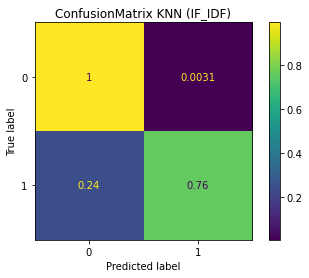

In [46]:
ConfusionMatrixDisplay.from_estimator(knn_tf_fit_read,X_test_tf, y_test,normalize='true')
plt.title('ConfusionMatrix KNN (IF_IDF)')
plt.show()

In [157]:
knn_tf_fit_read.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 3, 3]),
 'n_resources': array([  463,   463,   463,   463,   463,   463,   463,   463,   463,
          463,   463,   463,   463,   463,   463,   463,   463,   463,
          463,   463,   463,   463,   463,   463,   463,   463,   463,
          463,   463,   463,   463,   463,   463,   463,   463,  1389,
         1389,  1389,  1389,  1389,  1389,  1389,  1389,  1389,  1389,
         1389,  1389,  4167,  4167,  4167,  4167, 12501, 12501]),
 'mean_fit_time': array([   7.70977116,    7.58650074,    7.86894517,    7.01323438,
           6.90871358,    7.32559915,    7.03657174,   30.20879531,
          30.21468382,   30.57282562,   30.16082144,   30.64383302,
          30.86823344,   30.10765014,   30.5690062 ,   30.67851415,
          29.70312915,   30.13667669,   30.92048783,   29.84905524,
          29.5

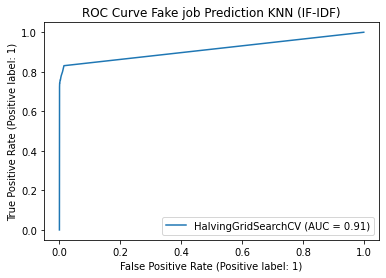

In [48]:
RocCurveDisplay.from_estimator(knn_tf_fit_read,X_test_tf, y_test)
plt.title('ROC Curve Fake job Prediction KNN (IF-IDF)')
plt.show()

**Best result:**
- The best result for KNN (IF_IDF) is test acurrcy score 0.985, with the AUC 0.91.
- This model predict 100% of TN, but only 76% of the TP. 

**Best model model KNN**

| Best estimator  Model 4                                                                                                                                            | model | Vectorizer | Test Accuracy      | % TP | % TN | AUC  |   |   |   |   |
|:------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:-----:|:----------:|:------------------:|:----:|:----:|:----:|:---:|:---:|:---:|:---:|
| 'classifier': KNeighborsClassifier(n_jobs=-1, n_neighbors=9), 'classifier__n_neighbors': 9, 'dim_reducer': PCA(n_components=0.8), 'dim_reducer__n_components': 0.8 | KNN   | IF-IDF     | 0.9852721849366145 | 0.76 | 1    | 0.91 |   |   |   |   |

# 3.5 Random Forests<a id="3.5"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Random Forests will benefit from carefully Hyperparameter tune, this will increase computing time. I will runing a basic model for RT trees for time managerment reason, will come back later to do some enhance job later.

**plan**
- Find a better n_estimators
 + split reminder into validation and train set, to run a default RT model to find a smaller n_estimator range.
- implement gridsearch

**some variable use in this session:**
- X_rem_count (X_reminder vectorized by CountVectorizer)
- X_rem_tf (X_reminder vectorized by TF_IDF)
- X_test_tf (x_test vectorized by TF_IDF)

In [18]:
# split reminder data into train and validation (CountVectorizer)
X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(X_rem_count, y_rem, test_size=0.2, random_state=42,stratify=y_rem)

In [16]:
# basic Hyperparameter (CountVectorizer) tune to find a samller n_estimators range
n_lst=list(range(100,1050,50))
train_acc_count=[]
val_acc_count=[]
for n in n_lst:
    estimators=[
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()),
    ('classifier',RandomForestClassifier(n_estimators=n,n_jobs=-1))]
    pipe_rt_0=imbPipeline(estimators)
    pipe_rt_0.fit(X_train_count,y_train_count)
    train_acc=pipe_rt_0.score(X_train_count,y_train_count)
    val_acc=pipe_rt_0.score(X_val_count,y_val_count)
    train_acc_count.append(train_acc)
    val_acc_count.append(val_acc)

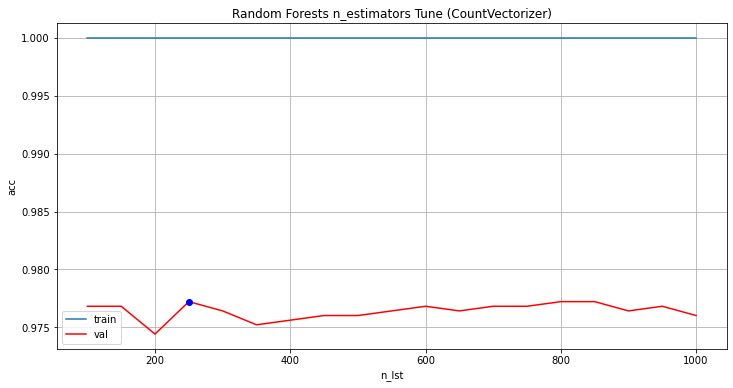

In [48]:
plt.figure(figsize=(12,6))
plt.plot(n_lst,train_acc_count,label='train')
plt.title('Random Forests n_estimators Tune (CountVectorizer)')
plt.plot(n_lst,val_acc_count,label='val',color='red')
plt.plot(n_lst[np.array(val_acc_count).argmax()],max(val_acc_count),'ro',color='blue')
plt.xlabel('n_lst')
plt.grid()
plt.ylabel('acc')
plt.legend()
plt.show()

In [33]:
max_index=np.array(val_acc_count).argmax()
max_index

3

In [35]:
# best n_estimators is 250
n_lst[max_index]

250

**n_estimators range (CountVectorizer)**:
- The best n_estimators in the experiment above is 250, I will use 200 to 420 as the n_estimators range.
- The random forests model is overfitted in all these test I ran above.

In [19]:
# split reminder data into train and validation (IF_IDF)
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(X_rem_tf, y_rem, test_size=0.2, random_state=42,stratify=y_rem)

In [36]:
# basic Hyperparameter (if_idf) tune to find a samller n_estimators range
n_lst=list(range(100,1050,50))
train_acc_tf=[]
val_acc_tf=[]
for n in n_lst:
    estimators=[
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()),
    ('classifier',RandomForestClassifier(n_estimators=n,n_jobs=-1))]
    pipe_rt_0=imbPipeline(estimators)
    pipe_rt_0.fit(X_train_tf,y_train_tf)
    train_acc=pipe_rt_0.score(X_train_tf,y_train_tf)
    val_acc=pipe_rt_0.score(X_val_tf,y_val_tf)
    train_acc_tf.append(train_acc)
    val_acc_tf.append(val_acc)

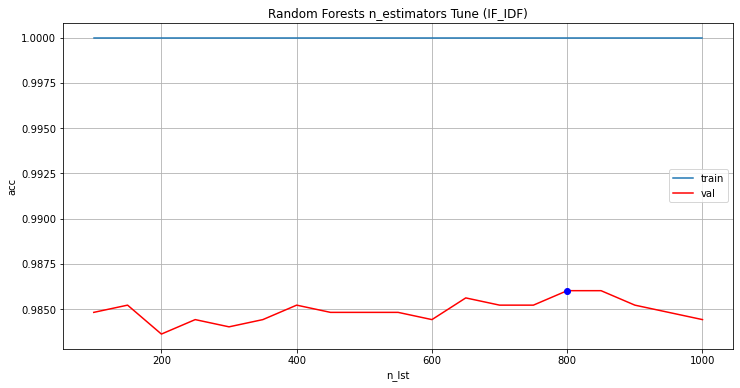

In [47]:
plt.figure(figsize=(12,6))
plt.plot(n_lst,train_acc_tf,label='train')
plt.title('Random Forests n_estimators Tune (IF_IDF)')
plt.plot(n_lst,val_acc_tf,label='val',color='red')
plt.plot(n_lst[np.array(val_acc_tf).argmax()],max(val_acc_tf),'ro',color='blue')
plt.xlabel('n_lst')
plt.ylabel('acc')
plt.grid()
plt.legend()
plt.show()

In [44]:
print(n_lst)

[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]


In [42]:
max_index_rt_tf=np.array(val_acc_tf).argmax()
n_lst[max_index_rt_tf]

800

**n_estimators range (if_idf)**:
- The best n_estimators in the experiment is 800, I will use 650 to 900 as the n_estimators range.
- The random forests model is overfitted in all these test I ran above.

In [9]:
# pipeline for random forest
pipe_rt=imbPipeline([
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()), # choose MinMaxScaler(), as I don't want to change the distribustion of features ans target 
    ('dim_reducer', PCA()),
    ('classifier',RandomForestClassifier())
])

n_list=list(range(200,420,20))
grid_rt=[{
    'dim_reducer':[None],
    'classifier__n_estimators':n_list,
    'classifier':[RandomForestClassifier(n_jobs=-1)]
},
{   'dim_reducer':[PCA()],
    'dim_reducer__n_components':[0.95, 0.9, 0.85, 0.8],
    'classifier__n_estimators':n_list,
    'classifier':[RandomForestClassifier(n_jobs=-1)]
}        
]

In [10]:
# RT GridSearch
rt_hv=HalvingGridSearchCV(pipe_rt,grid_rt,n_jobs=-1, min_resources="exhaust", factor=3,verbose=2)

**CountVectorizer**

In [ ]:
rt_count_fit=rt_hv.fit(X_rem_count, y_rem)

In [13]:
# dump with pickle capture result from cell 79
with open('vectorized_df/rt_count_fit.pkl', 'wb') as f:
    pickle.dump(rt_count_fit, f)

In [14]:
rt_count_fit_read=joblib.load('vectorized_df/rt_count_fit.pkl')

In [15]:
print(f"The best estimator for Random Forests (CountVectorizer){rt_count_fit_read.best_params_}")

The best estimator for Random Forests (CountVectorizer){'classifier': RandomForestClassifier(n_estimators=320, n_jobs=-1), 'classifier__n_estimators': 320, 'dim_reducer': PCA(n_components=0.8), 'dim_reducer__n_components': 0.8}


In [16]:
rt_count_fit_read.score(X_test_count, y_test)

0.9733407904548844

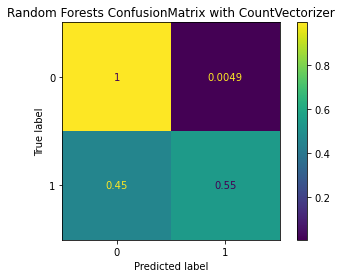

In [17]:
ConfusionMatrixDisplay.from_estimator(rt_count_fit_read,X_test_count, y_test,normalize='true')
plt.title('Random Forests ConfusionMatrix with CountVectorizer')
plt.show()

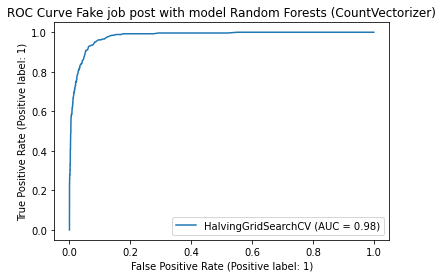

In [18]:
RocCurveDisplay.from_estimator(rt_count_fit_read,X_test_count, y_test)
plt.title('ROC Curve Fake job post with model Random Forests (CountVectorizer)')
plt.show()

**Best result:**
- The best result for Random Forests (CountVectorizer) is test acurrcy score 0.968, with the AUC 0.98.
- This model predict 99% of TN, but only 55% of the TP. Clearly this model does not have a superior ability for dectect FAKE JOBS. 

**IF-IDF**

- note: This fit process will take a very long time, you can skip this step by loading my fit result.
- Accroding to the approach above, I will use  **700 to 920** as the n_estimators range.

In [11]:
# pipeline for random forest (TF_IDF)
pipe_rt_tf=imbPipeline([
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()), # choose MinMaxScaler(), as I don't want to change the distribustion of features ans target 
    ('dim_reducer', PCA()),
    ('classifier',RandomForestClassifier())
])

n_list_tf=list(range(700,920,20))
grid_rt_1=[{
    'dim_reducer':[None],
    'classifier__n_estimators':n_list,
    'classifier':[RandomForestClassifier(n_jobs=-1)]
},
{   'dim_reducer':[PCA()],
    'dim_reducer__n_components':[0.95, 0.9, 0.85, 0.8],
    'classifier__n_estimators':n_list_tf,
    'classifier':[RandomForestClassifier(n_jobs=-1)]
}]    


In [12]:
n_list_tf

[700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900]

In [13]:
# RT GridSearch (if_iDF)
rt_hv_tf=HalvingGridSearchCV(pipe_rt_tf,grid_rt_1,n_jobs=-1, min_resources="exhaust", factor=3,verbose=2)

In [14]:
rt_tf_fit=rt_hv_tf.fit(X_rem_tf, y_rem)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 463
max_resources_: 12515
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 55
n_resources: 463
Fitting 5 folds for each of 55 candidates, totalling 275 fits
----------
iter: 1
n_candidates: 19
n_resources: 1389
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 2
n_candidates: 7
n_resources: 4167
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 3
n_resources: 12501
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [15]:
# dump result
joblib.dump(rt_tf_fit, 'vectorized_df/rt_tf_fit.pkl')

['vectorized_df/rt_tf_fit.pkl']

In [13]:
# load pre fit randomforests (IF_IDF)
rt_tf_fit_read=joblib.load('vectorized_df/rt_tf_fit.pkl')

In [72]:
print(f"Best estimator for Random Forests (TF_IDF) is {rt_tf_fit_read.best_params_}")

Best estimator for Random Forests (TF_IDF) is {'classifier': RandomForestClassifier(n_estimators=690, n_jobs=-1), 'classifier__n_estimators': 690, 'dim_reducer': None}


In [17]:
rt_tf_fit_read.score(X_test_tf, y_test)

0.9832214765100671

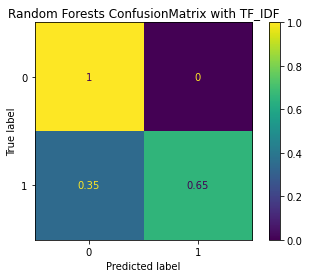

In [19]:
ConfusionMatrixDisplay.from_estimator(rt_tf_fit_read,X_test_tf, y_test,normalize='true')
plt.title('Random Forests ConfusionMatrix with TF_IDF')
plt.show()

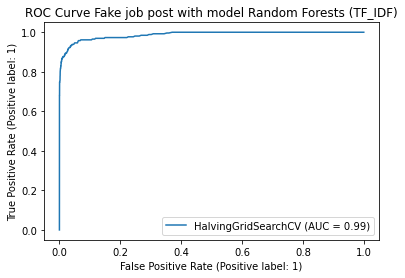

In [20]:
RocCurveDisplay.from_estimator(rt_tf_fit_read,X_test_tf, y_test)
plt.title('ROC Curve Fake job post with model Random Forests (TF_IDF)')
plt.show()

**Best result:**
- The best result for Random Forests (TF_IDF) is test acurrcy score 0.983, with the AUC 0.99.
- This model predict 100% of TN, but 65% of the TP. Compare with the previous model, this one has a better performance. 

**Best model model Random Forests**

| Best estimator  Model 5                                                                                                 | model          | Vectorizer | Test Accuracy      | % TP  | % TN | AUC  |   |   |   |   |
|:-----------------------------------------------------------------------------------------------------------------------:|:--------------:|:----------:|:------------------:|:-----:|:----:|:----:|:---:|:---:|:---:|:---:|
| 'classifier': RandomForestClassifier(n_estimators=690, n_jobs=-1), 'classifier__n_estimators': 690, 'dim_reducer': None | Random Forests | IF-IDF     | 0.9832214765100671 | 0.65	 | 1    | 0.99 |   |   |   |   |

# 3.6 XGBoost<a id="3.6"></a>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

**plan**
- Find a better n_estimators
 + split reminder into test and validate set finding a better n_estimators (Already done this is in the dummy base model session)
- implement gridsearch

**some variable use in this session:**
- X_rem_count (X_reminder vectorized by CountVectorizer)
- X_rem_tf (X_reminder vectorized by TF_IDF)
- X_test_tf (x_test vectorized by TF_IDF)

**Find a proper n**

In [21]:
n_list=[50,100,200,300,500,700,900,1000]
train_acc_xg_c=[]
val_acc_xg_c=[]
for n in n_list:
    estimators=[
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()),
    ('classifier',RandomForestClassifier(n_estimators=n,n_jobs=-1))]
    pipe_xg_0=imbPipeline(estimators)
    pipe_xg_0.fit(X_train_count,y_train_count)
    train_acc=pipe_xg_0.score(X_train_count,y_train_count)
    val_acc=pipe_xg_0.score(X_val_count,y_val_count)
    train_acc_xg_c.append(train_acc)
    val_acc_xg_c.append(val_acc)

In [23]:
val_acc_xg_c

[0.9760287654814223,
 0.9776268477826608,
 0.9772273272073512,
 0.9760287654814223,
 0.9780263683579704,
 0.9756292449061127,
 0.9776268477826608,
 0.9772273272073512]

In [22]:
train_acc_xg_c

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

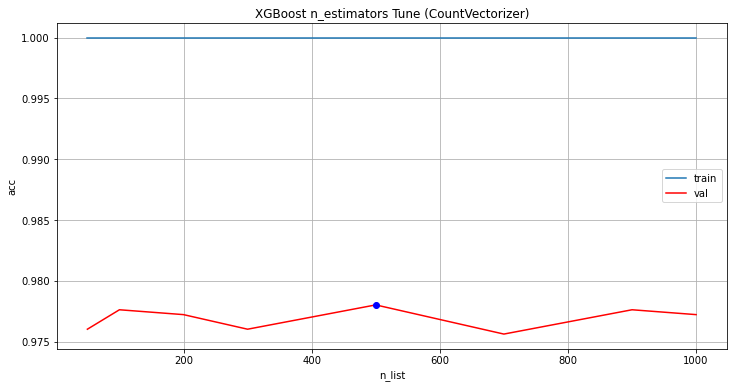

In [24]:
plt.figure(figsize=(12,6))
plt.plot(n_list,train_acc_xg_c,label='train')
plt.title('XGBoost n_estimators Tune (CountVectorizer)')
plt.plot(n_list,val_acc_xg_c,label='val',color='red')
plt.plot(n_list[np.array(val_acc_xg_c).argmax()],max(val_acc_xg_c),'ro',color='blue')
plt.xlabel('n_list')
plt.ylabel('acc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# dump result
#joblib.dump(rt_tf_fit, 'vectorized_df/rt_tf_fit.pkl')

In [25]:
pipe_xg=imbPipeline([
    ('smote',SMOTE(random_state=42)),
    ('scaler',MinMaxScaler()), # choose MinMaxScaler(), as I don't want to change the distribustion of features ans target 
    ('dim_reducer', PCA()),
    ('classifier',XGBClassifier())
])

n_list_xg=list(range(400,600,10))
grid_xg=[{
    'dim_reducer':[None],
    'classifier__n_estimators':n_list_xg,
    'classifier':[XGBClassifier(n_jobs=-1)]
},
{   'dim_reducer':[PCA()],
    'dim_reducer__n_components':[0.95, 0.9, 0.85, 0.8],
    'classifier__n_estimators':n_list,
    'classifier':[XGBClassifier(n_jobs=-1,)]
}        
]

In [27]:
# xgboost GridSearch (CountVectorizer)
xg_hv_count=HalvingGridSearchCV(pipe_xg,grid_xg,n_jobs=-1, min_resources="exhaust", factor=3,verbose=2)

In [ ]:
xg_count_fit=xg_hv_count.fit(X_rem_count, y_rem)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 463
max_resources_: 12515
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 52
n_resources: 463
Fitting 5 folds for each of 52 candidates, totalling 260 fits
----------
iter: 1
n_candidates: 18
n_resources: 1389
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 4167
Fitting 5 folds for each of 6 candidates, totalling 30 fits
